In [28]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch

from matplotlib.colors import LinearSegmentedColormap

from dataset import get_loader, get_data, get_normalization_param, get_transform

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
from captum.attr import visualization as viz

from models import get_model

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "checkpoints/_nPT_resnet10/model-bacc.ckpt"
model_name = 'resnet10'

model_state_dict = torch.load(model_path, map_location=torch.device(device))
model = get_model(model_name, device)
model.load_state_dict(model_state_dict)
model.eval()

<All keys matched successfully>

In [24]:
basepath = "/data1/TBM/data_for_AI/data/realigned_pt/"
csvpath = '/data1/TBM/data_for_AI/subjects_info/final_TBM_subjects_info.csv'
mask_basepath = "/data1/TBM/data_for_AI/new_data/DTI/nodif_brain_mask"
modality = {
        'basepath': "/data1/TBM/data_for_AI/new_data/DTI/nPT",
        'modality': 'nPT',
        'use_file': None,
        'prefix': '',
        'suffix': '_wnfdt_paths.nii'
    }
random_state = 42
img_size = 64

filenames, mask_filenames, labels_data, no_data = get_data(
        csvpath, 
        modality['basepath'], 
        mask_basepath,
        random_state,
        modality = modality['modality'],
        use_file=modality['use_file'],
        prefix = modality['prefix'],
        suffix = modality['suffix'],)

all_index = list(range(961))
test_size = 0.1
val_size = 0.2
train_index, test_index = train_test_split(all_index,  test_size= test_size, random_state=random_state)
train_index, val_index = train_test_split(train_index,  test_size= val_size, random_state=random_state)

print(f"{modality['modality']}: {no_data}")
print(len(filenames))
x_train = [filenames[i] for i in train_index]
x_val = [filenames[i] for i in val_index]
x_test = [filenames[i] for i in test_index]

y_train = [labels_data[i] for i in train_index]
y_val = [labels_data[i] for i in val_index]
y_test = [labels_data[i] for i in test_index]

mean_data, std_data = get_normalization_param(x_train, mask_filenames)

train_transform = get_transform(mean_data, std_data, mode = 'train')
val_transform = get_transform(mean_data, std_data, mode = 'val')

train_loader = get_loader(x_train, y_train, train_transform, mode = 'train', batch_size =1, img_size = img_size)
val_loader = get_loader(x_val, y_val,val_transform, mode = 'val', batch_size =1, img_size = img_size)

nPT: ['normal_0054', 'normal_0380', 'normal_0470', 'normal_0531', 'normal_0546', 'normal_0553', 'normal_0555', 'normal_0766', 'normal_0768', 'normal_0769', 'mci_0116', 'mci_0120']
961


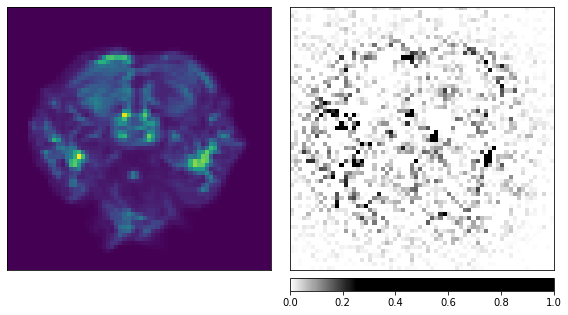

In [46]:
target_layers = [model.layer4[-1]]

# ลองทำของคนเดียว
for img, label in val_loader:
    input_tensor = img
    break

# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
ig = IntegratedGradients(model)
attributions_ig  = ig.attribute(input_tensor.cuda(), target=0) 


default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy()[20:21,:,:], (1,2,0)),
                             np.transpose(input_tensor.squeeze().cpu().detach().numpy()[20:21,:,:], (1,2,0)),
                             ["original_image", "heat_map"],
                                      ["all", "positive"],
                             cmap=default_cmap,
                             show_colorbar=True)

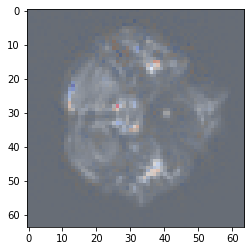

In [60]:
plt.imshow(np.transpose(attributions_ig.squeeze().cpu().detach().numpy()[20:21,:,:]), alpha=1, cmap = 'coolwarm')
plt.imshow(np.transpose(input_tensor.squeeze().cpu().detach().numpy()[20:21,:,:]), alpha = 0.5, cmap = 'gray')


In [37]:
attributions_ig.squeeze().cpu().detach().numpy().shape

(64, 64, 64)

In [38]:
attributions_ig.size()

torch.Size([1, 1, 64, 64, 64])